# 🧭 From Raw Q&A to Specialty Taxonomy (Unsupervised → Minimal Hybrid)

## 🎯 Goals

Create a first-pass specialty label (y) for each record using an **ML-first approach**:

1. **Build text representations** (embeddings)
2. **Explore structure** (UMAP visualization)
3. **Learn k-means clustering** and choose k with evidence
4. **Manually name clusters** → preliminary taxonomy
5. **Add 5–10 surgical rules** for obvious fixes (hybrid)
6. **Export a clean dataset** with specialty for downstream supervised learning

### Why this design?

You're learning **clustering**. Rules are allowed only to patch systematic misses, not to replace ML discovery.

### 📦 Deliverables

- `data/processed/specialty_taxonomy_v1.csv` (includes specialty)
- `artifacts/cluster_label_map_v1.json` (cluster → human label)
- `artifacts/umap_2d.parquet` (2D coords for plots)

---


## 📝 Decisions Log

**Document your key decisions here as you work through the notebook:**

### Embedding Model Choice
- **Model:** _[TODO: Fill this in after completing Section 3]_
- **Why:** _[Explain your reasoning: medical vs. general, speed vs. quality]_

### BEST_K Choice
- **k =** _[TODO: Fill this in after completing Section 4]_
- **Evidence:** _[1-2 paragraphs: What did the elbow curve show? What was the silhouette score? Why did you choose this k?]_

### Surgical Rules (5-10 max)
_[TODO: Fill this in after completing Section 9]_

1. **Rule 1:** _[What pattern? → Which specialty? Why needed?]_
2. **Rule 2:** _[...]_
3. ...

---


## 0️⃣ Imports, Config, Paths


In [5]:
# [TODO] Imports
# Hint: pandas, numpy, pathlib, json, matplotlib, sklearn (KMeans, silhouette_score), 
#       umap-learn, sentence-transformers
import pandas as pd
import numpy as np
import pathlib
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import umap
from sentence_transformers import SentenceTransformer
from pathlib import Path
import seaborn as sns


# [TODO] Set a reproducible seed (e.g., 42) for KMeans and UMAP
# Hint: np.random.seed, random.seed, pass random_state=SEED in models
random_state = 42



# [TODO] Define paths (Pathlib recommended)
# DATA_RAW = Path("../../../datasets/medquad.csv")
# DATA_OUT = Path("../data/processed")
# ARTIFACTS = Path("../artifacts")
# Ensure directories exist (mkdir parents=True, exist_ok=True)
DATA_RAW = Path("../../../datasets/medquad.csv")
DATA_OUT = Path("../../../data/processed")
ARTIFACTS = Path("../artifacts")

# Only create directories if they do not already exist
if not DATA_OUT.exists():
    DATA_OUT.mkdir(parents=True, exist_ok=True)

if not ARTIFACTS.exists():
    ARTIFACTS.mkdir(parents=True, exist_ok=True)



## 1️⃣ Load Data

We'll build one text unit per record. Best default for specialty inference is **question + answer concatenated** (more context). If you only have one field, just use it.

### Assumptions (edit as needed):
- Columns available: `focus_area`, `question`, `answer`
- Final text column: `text` (we'll create this by combining question + answer)

In [11]:
# [TODO] Load CSV
# df = pd.read_csv(DATA_RAW)
df = pd.read_csv(DATA_RAW)

# [TODO] Sanity check columns and row count
# print(df.columns); df.head()
# print(df.head())

# [TODO] Build the `text` column.
# Hint: Prefer question + " " + answer; fall back if a column is missing.
# df["text"] = ...
df["text"] = df["question"] + " " + df["answer"]

# [TODO] Drop completely empty/NaN texts and trim whitespace
df = df[~df["text"].isna()].copy()
df["text"] = df["text"].str.strip()

# [TODO] Optional: keep only essential columns or add an ID if missing
# If no ID exists: df['id'] = range(len(df))
df['id'] = range(len(df))
df = df[['id', 'text']]
print(df.head())


   id                                               text
0   0  What is (are) Glaucoma ? Glaucoma is a group o...
1   1  What causes Glaucoma ? Nearly 2.7 million peop...
2   2  What are the symptoms of Glaucoma ? Symptoms o...
3   3  What are the treatments for Glaucoma ? Althoug...
4   4  What is (are) Glaucoma ? Glaucoma is a group o...


## 2️⃣ Light Preprocessing

Transformers don't need heavy cleaning. Keep it minimal:

- ✅ Normalize whitespace
- ❓ Lowercasing (optional - embeddings handle case)
- ❌ No stemming/lemmatization
- ❌ Keep domain terms (don't strip "diabetes", "TNM", etc.)

In [13]:
# [TODO] Minimal normalization step(s)
# Hint: df["text_proc"] = df["text"].str.replace(r"\s+", " ", regex=True)
# Optional: .str.lower() if you want
# Decide and document it in a variable, e.g., USE_LOWER = False
df["text_proc"] = df["text"].str.replace(r"\s+", " ", regex=True)
df["text_proc"] = df["text_proc"].str.strip().str.lower()




# Print a few samples to verify
print(df.head())

   id                                               text  \
0   0  What is (are) Glaucoma ? Glaucoma is a group o...   
1   1  What causes Glaucoma ? Nearly 2.7 million peop...   
2   2  What are the symptoms of Glaucoma ? Symptoms o...   
3   3  What are the treatments for Glaucoma ? Althoug...   
4   4  What is (are) Glaucoma ? Glaucoma is a group o...   

                                           text_proc  
0  what is (are) glaucoma ? glaucoma is a group o...  
1  what causes glaucoma ? nearly 2.7 million peop...  
2  what are the symptoms of glaucoma ? symptoms o...  
3  what are the treatments for glaucoma ? althoug...  
4  what is (are) glaucoma ? glaucoma is a group o...  


## 3️⃣ Embeddings

Use a **sentence embedding model**. Options:

### Medical-leaning models:
- `pritamdeka/BioBERT-mnli-snli-scitail-mednli` (best for medical text)
- `dmis-lab/biobert-base-cased-v1.1` (needs sentence-transformers wrapper)

### General baseline models:
- `sentence-transformers/all-MiniLM-L6-v2` (fast, decent, 384-dim)
- `sentence-transformers/all-mpnet-base-v2` (slower, better, 768-dim)

### Trade-off:
- **Medical models** = better semantics for clinical terms
- **General model** = faster & lighter

**Pick one and state why in the Decisions Log above!**

In [18]:
# [TODO] Load a SentenceTransformer model by name
# Hint: from sentence_transformers import SentenceTransformer
# model = SentenceTransformer("<model-name>")
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

# [TODO] Compute embeddings for df["text_proc"] (or df["text"])
X = model.encode(df["text_proc"].tolist(), batch_size=32, show_progress_bar=True, 
                 convert_to_numpy=True, normalize_embeddings=True)


# [TODO] Sanity check shape: (n_samples, embedding_dim)
print(f"Embeddings shape: {X.shape}")
# Expected: (16398, 384) or (16398, 768) depending on model

Batches:   0%|          | 0/513 [00:00<?, ?it/s]

Embeddings shape: (16407, 768)


## 4️⃣ Picking k: Evidence over Vibes

You'll learn k-means by comparing k values:

### Two Key Metrics:

1. **Inertia (distortion):** Sum of squared distances to cluster centers
   - Goes down with higher k (use elbow to find diminishing returns)
   - Look for the "elbow" where improvement flattens

2. **Silhouette score:** Measures cluster separation quality
   - Range: [-1, 1], higher is better
   - > 0.5 = good separation
   - 0.3-0.5 = reasonable
   - < 0.3 = poor/overlapping clusters

### Strategy:
Try k in `[8, 10, 12, 14, 16, 18, 20, 22, 24, 26]` (adjust for dataset size). 

Choose a **justified k** (not perfect, just argued with evidence).

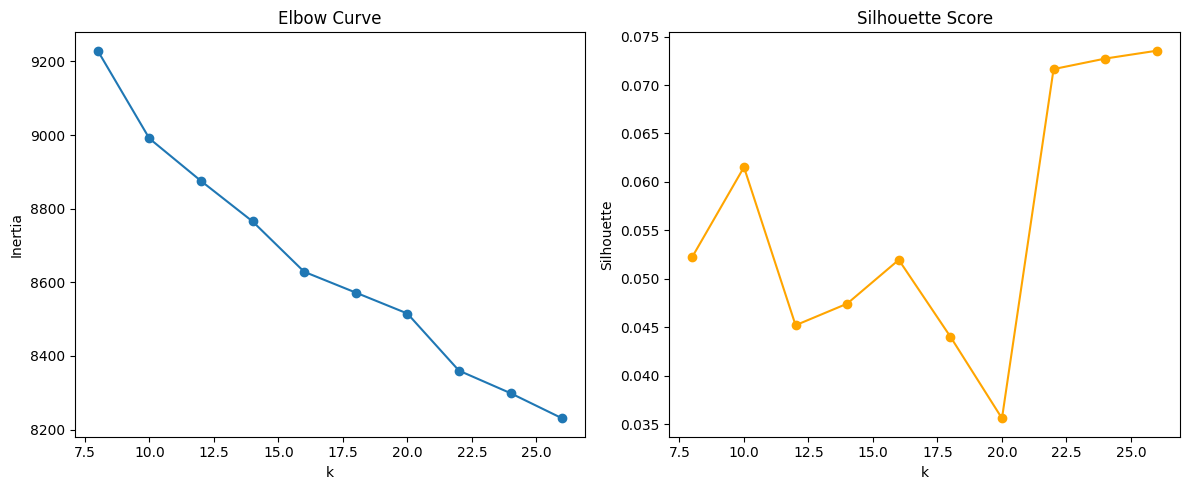

<Figure size 640x480 with 0 Axes>

In [22]:
# [TODO] Define K_RANGE = list(range(8, 27, 2))  # example: step by 2
K_RANGE = list(range(8, 27, 2))

# [TODO] For each k:
#   - fit KMeans(n_clusters=k, n_init="auto" or 10+, random_state=SEED)
#   - record inertia_
#   - compute silhouette_score(X, labels)  # may be slow on huge data; sample if needed
# Hint: Store results in two lists: inertias = [], silhouettes = []
inertias = []
silhouettes = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))


# [TODO] Plot k vs inertia (elbow curve)
# Hint: plt.figure(figsize=(12,5))
#       plt.subplot(1,2,1) for inertia
#       plt.plot(K_RANGE, inertias, marker='o')
#       plt.xlabel('k'), plt.ylabel('Inertia'), plt.title('Elbow Curve')
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_RANGE, inertias, marker='o')
plt.xlabel('k'), plt.ylabel('Inertia'), plt.title('Elbow Curve')


# [TODO] Plot k vs silhouette score
#       plt.subplot(1,2,2) for silhouette
#       plt.plot(K_RANGE, silhouettes, marker='o', color='orange')
#       plt.xlabel('k'), plt.ylabel('Silhouette'), plt.title('Silhouette Score')
#       plt.tight_layout(), plt.show()
plt.subplot(1,2,2)
plt.plot(K_RANGE, silhouettes, marker='o', color='orange')
plt.xlabel('k'), plt.ylabel('Silhouette'), plt.title('Silhouette Score')
plt.tight_layout()
plt.show()

# Save to images with the correct name
import os
os.makedirs("../images", exist_ok=True)
plt.savefig("../images/elbow_silhouette.png")

# [TODO] Based on these plots, set BEST_K = ...
BEST_K = 22
print(f"✅ Chosen k = {BEST_K}")
# Now go back to the Decisions Log and document WHY you chose this k!

## 5️⃣ Train Final KMeans

Now fit the final model with your chosen `BEST_K`. This is the **unsupervised "discovery" step** that gives you cluster IDs.

### What KMeans Does:
1. Randomly initialize k cluster centers
2. Assign each point to nearest center
3. Move centers to mean of assigned points
4. Repeat steps 2-3 until convergence
5. Output: cluster_id for each sample

In [ ]:
# [TODO] Fit final KMeans with BEST_K
km = KMeans(n_clusters=BEST_K, n_init=10, random_state=random_state, verbose=1)
# cluster_ids = km.fit_predict(X)


# [TODO] Attach cluster_ids to df
# df["cluster_id"] = cluster_ids


# [TODO] Check cluster size distribution
# df["cluster_id"].value_counts().sort_index()

## 6️⃣ Visualize Structure with UMAP

**Visualization is for your brain, not the algorithm.** 

Use UMAP (2D) to inspect the structure and color by cluster. This won't change labels; it helps you **understand what k-means found**.

### UMAP Parameters:
- `n_neighbors`: Local vs. global structure (15 is a good default)
- `min_dist`: How tightly to pack points (0.1 is standard)
- `metric`: Use "cosine" for text embeddings

In [ ]:
# [TODO] Fit UMAP on X → 2D
# Hint: import umap
# umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, 
#                        metric="cosine", random_state=SEED, verbose=True)
# Z = umap_model.fit_transform(X)


# [TODO] Save Z to artifacts for reuse
# Convert Z to a DataFrame with id, cluster_id, x, y and save as parquet
# umap_df = pd.DataFrame({
#     'id': df['id'],
#     'cluster_id': df['cluster_id'],
#     'umap_x': Z[:, 0],
#     'umap_y': Z[:, 1]
# })
# umap_df.to_parquet(ARTIFACTS / "umap_2d.parquet", index=False)


# [TODO] Simple scatter plot: x vs y, colored by cluster_id
# plt.figure(figsize=(14, 10))
# scatter = plt.scatter(Z[:, 0], Z[:, 1], c=df['cluster_id'], 
#                       cmap='tab20', s=5, alpha=0.6)
# plt.colorbar(scatter, label='Cluster ID')
# plt.xlabel('UMAP 1'), plt.ylabel('UMAP 2')
# plt.title(f'UMAP Projection (k={BEST_K} clusters)')
# plt.tight_layout()
# plt.show()

## 7️⃣ Understand Clusters: Representatives & Keywords

Before naming clusters, explore what's inside them:

### Two Techniques:

1. **Representatives:** Show 10 sample texts per cluster
   - Gives you a "feel" for what the cluster contains
   - Look for common themes

2. **Keywords per cluster:** Compute TF-IDF on texts within each cluster
   - Surfaces the most distinctive terms
   - This is descriptive analysis, not the clustering itself

You'll use these to **manually map cluster → specialty**.

In [ ]:
# [TODO] For each cluster_id:
#   - print count
#   - show N (e.g., 10) representative texts (shortened to first 200 chars)
# Hint: 
# for cluster_id in sorted(df['cluster_id'].unique()):
#     cluster_df = df[df['cluster_id'] == cluster_id]
#     print(f"\n{'='*80}")
#     print(f"Cluster {cluster_id} | Size: {len(cluster_df)}")
#     print(f"{'='*80}")
#     samples = cluster_df.sample(n=min(10, len(cluster_df)), random_state=SEED)
#     for idx, row in samples.iterrows():
#         print(f"  • {row['text'][:200]}...")

In [ ]:
# [TODO] Compute cluster-wise TF-IDF keywords
# For each cluster, fit a TF-IDF on its texts and extract top N terms
# Hint: 
# from sklearn.feature_extraction.text import TfidfVectorizer
# 
# for cluster_id in sorted(df['cluster_id'].unique()):
#     cluster_texts = df[df['cluster_id'] == cluster_id]['text_proc'].tolist()
#     
#     if len(cluster_texts) < 5:  # Skip tiny clusters
#         continue
#     
#     vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1,2), 
#                                   stop_words='english', min_df=2)
#     tfidf_matrix = vectorizer.fit_transform(cluster_texts)
#     feature_names = vectorizer.get_feature_names_out()
#     
#     # Get top terms
#     scores = tfidf_matrix.sum(axis=0).A1
#     top_indices = scores.argsort()[-15:][::-1]
#     top_terms = [feature_names[i] for i in top_indices]
#     
#     print(f"\nCluster {cluster_id} keywords: {', '.join(top_terms)}")

## 8️⃣ Manual Cluster Naming

Create a mapping from `cluster_id → specialty` (your taxonomy). 

### Guidelines:
- Keep names consistent (e.g., "Oncology", "Endocrinology & Diabetes", "Neurology & Neurosurgery", "Cardiology")
- Don't overfit—**broad buckets are fine**
- Use the representatives and keywords from Section 7 to guide your choices
- If a cluster is truly mixed, pick the dominant theme or use "General Medicine"

### Suggested Specialty Names:
- Oncology
- Infectious Diseases
- Cardiology & Vascular
- Neurology & Neurosurgery
- Endocrinology & Diabetes
- Gastroenterology & Hepatology
- Nephrology & Urology
- Pulmonology & Respiratory
- Immunology & Rheumatology
- Hematology
- Dermatology
- Ophthalmology
- Obstetrics & Gynecology
- Pediatrics & Development
- Genetics & Rare Disorders
- General & Preventive Medicine

Save your mapping to JSON so it's **reproducible**.

In [ ]:
# [TODO] Create a dict: cluster_label_map = {0: "Oncology", 1: "Cardiology", ...}
# Start empty and fill as you inspect exploration outputs from Section 7

cluster_label_map = {
    # Example:
    # 0: "Oncology",
    # 1: "Infectious Diseases",
    # 2: "Cardiology & Vascular",
    # ... fill in all clusters
}

# [TODO] Validate: all cluster_ids present have a mapping
# missing = set(df["cluster_id"].unique()) - set(cluster_label_map.keys())
# if missing:
#     raise ValueError(f"Missing mappings for clusters: {missing}")


# [TODO] Apply mapping
# df["specialty"] = df["cluster_id"].map(cluster_label_map)


# [TODO] Save mapping to artifacts as JSON
# with open(ARTIFACTS / "cluster_label_map_v1.json", "w") as f:
#     json.dump(cluster_label_map, f, indent=2, sort_keys=True)
# print("✅ Saved cluster_label_map_v1.json")


# [TODO] Check distribution
# df["specialty"].value_counts().sort_values(ascending=False)

## 9️⃣ Minimal Hybrid Patches (Strictly 5–10 Rules)

Now add **only a handful of surgical overrides** for systematic misses you observed.

### Philosophy:
- **Rules are a band-aid, not a cast**
- If you feel tempted to add rule #11, revisit clustering (k, embeddings) instead
- Keep them transparent and minimal—this is still an **ML-first taxonomy**

### Examples of Categories Worth Patches:
1. `"cancer" / "carcinoma" / "sarcoma"` → **Oncology**
2. `"diabetes" / "hyperglycemia" / "insulin"` → **Endocrinology & Diabetes**
3. `"pregnancy" / "obstetric" / "antenatal"` → **Obstetrics & Gynecology**
4. `"stroke" / "epilepsy" / "parkinson"` → **Neurology & Neurosurgery**
5. `"heart" / "coronary" / "cardiac"` → **Cardiology & Vascular**

**Pick only those that your clusters consistently confuse.**

In [ ]:
# [TODO] Define a small function override_specialty(text, current_label) -> label
# Hints:
# - Work on a lowercased version of text
# - Evaluate 5–10 if/elif checks MAX
# - Return either current_label (no change) or an override
# - Document each rule with a comment explaining WHY

def override_specialty(text: str, current_label: str) -> str:
    """
    Apply minimal surgical overrides for systematic clustering misses.
    
    Args:
        text: The original text (question + answer)
        current_label: The specialty assigned by clustering
    
    Returns:
        Either current_label (no override) or corrected specialty
    """
    text_lower = text.lower()
    
    # Rule 1: Cancer terms → Oncology
    # Why: Clustering sometimes groups rare cancers with genetic disorders
    # if any(term in text_lower for term in ["cancer", "carcinoma", "sarcoma", "tumor", "tumour"]):
    #     return "Oncology"
    
    # Rule 2: Diabetes → Endocrinology
    # Why: "diabetes" sometimes clusters with nephrology (kidney complications)
    # if "diabetes" in text_lower or "diabetic" in text_lower:
    #     return "Endocrinology & Diabetes"
    
    # [TODO] Add 3-8 more rules based on YOUR clustering results
    # Only add rules if you observe systematic errors!
    
    # No override matched → keep original
    return current_label


# [TODO] Apply to create specialty_v1_hybrid
# df["specialty_v1"] = df.apply(lambda r: override_specialty(r["text"], r["specialty"]), axis=1)


# [TODO] Inspect how many labels changed
# n_changed = (df["specialty_v1"] != df["specialty"]).sum()
# pct_changed = (df["specialty_v1"] != df["specialty"]).mean() * 100
# print(f"\n✅ Overrides applied: {n_changed:,} labels changed ({pct_changed:.2f}%)")


# [TODO] Show examples of what changed
# changed_df = df[df["specialty_v1"] != df["specialty"]][["text", "specialty", "specialty_v1"]]
# print("\nExample overrides:")
# display(changed_df.sample(min(10, len(changed_df)), random_state=SEED))

## 🔟 Quality Checks & Documentation

Quick sanity checks before exporting:

1. **Label distribution** (counts per specialty)
2. **Random samples** per specialty to eyeball correctness
3. **Silhouette score** for final BEST_K (already computed) → document value
4. **Write down** why you chose BEST_K (in Decisions Log at top)

In [ ]:
# [TODO] Value counts - check for balance and reasonableness
# specialty_counts = df["specialty_v1"].value_counts().sort_values(ascending=False)
# print("\n📊 Final Specialty Distribution:")
# print(specialty_counts)
# print(f"\nTotal specialties: {len(specialty_counts)}")
# print(f"Largest: {specialty_counts.iloc[0]} samples")
# print(f"Smallest: {specialty_counts.iloc[-1]} samples")
# print(f"Imbalance ratio: {specialty_counts.iloc[0] / specialty_counts.iloc[-1]:.1f}x")

In [ ]:
# [TODO] Random samples per specialty for eyeballing
# Sample 3-5 texts from each specialty and verify they make sense

# print("\n🔍 Quality Check: Random Samples per Specialty")
# print("="*80)
# for specialty in sorted(df["specialty_v1"].unique()):
#     print(f"\n📋 {specialty}")
#     print("-"*80)
#     samples = df[df["specialty_v1"] == specialty].sample(
#         n=min(3, len(df[df["specialty_v1"] == specialty])), 
#         random_state=SEED
#     )
#     for idx, row in samples.iterrows():
#         print(f"  • {row['text'][:150]}...")

## 1️⃣1️⃣ Save Outputs

These files are your **contract with downstream supervised notebooks**:

- `data/processed/specialty_taxonomy_v1.csv` (must contain: id, text, specialty)
- `artifacts/cluster_label_map_v1.json` (reproducible cluster → specialty mapping)
- `artifacts/umap_2d.parquet` (optional but helpful for viz reuse)

In [ ]:
# [TODO] Persist final labeled dataset
# OUT = DATA_OUT / "specialty_taxonomy_v1.csv"
# df_out = df[["id", "text"]].copy()
# df_out["specialty"] = df["specialty_v1"]
# df_out.to_csv(OUT, index=False)
# print(f"✅ Saved: {OUT}")
# print(f"   Shape: {df_out.shape}")
# print(f"   Columns: {list(df_out.columns)}")


# [TODO] Print all saved artifact paths for visibility
# print("\n📦 All Artifacts Saved:")
# print(f"  1. {OUT}")
# print(f"  2. {ARTIFACTS / 'cluster_label_map_v1.json'}")
# print(f"  3. {ARTIFACTS / 'umap_2d.parquet'}")

---

## 📚 Appendix A: K-means Intuition

### What it optimizes:
Minimizes **within-cluster squared distances** (inertia). Think: "each cluster has a center; assign points to nearest center; move centers; repeat."

### Why k matters:
- **Too small** → unrelated topics merged
- **Too large** → fragments one topic into many micro-clusters

### Why embeddings first:
Raw word counts miss context; embeddings place semantically similar texts closer in vector space.

### Why silhouette:
A simple measure of how well a point fits within its cluster vs. the next best cluster. Use it to avoid wishful thinking.

### Why UMAP:
Your eyes are good anomaly detectors. UMAP is for **understanding**, not for deciding labels.

---

## 📚 Appendix B: Minimal Rules Philosophy

### Key Principles:

1. **Rules are a band-aid, not a cast**
   - Use them to patch systematic errors, not replace ML
   - If you need many rules, your clustering needs improvement

2. **If you feel tempted to add rule #11:**
   - Revisit clustering parameters (k, embeddings model) instead
   - Consider using a better embedding model
   - Try different k values

3. **Document rules in plain language:**
   - Each rule: **what** pattern? → **which** specialty? **why** needed?
   - Example: "Cancer terms → Oncology. Why: k-means grouped rare cancers with genetic syndromes due to 'rare disease' semantic similarity."

4. **Prefer ML improvements over rules:**
   - Better embeddings (BioBERT vs. general model)
   - Different k (more/fewer clusters)
   - Alternative clustering (hierarchical, HDBSCAN)

---

## ✅ Next Steps

When you're done with this notebook:

1. **Go back to Decisions Log** at the top and fill in all sections
2. **Verify all artifacts exist:**
   - `data/processed/specialty_taxonomy_v1.csv`
   - `artifacts/cluster_label_map_v1.json`
   - `artifacts/umap_2d.parquet`

3. **Proceed to `01_project_scope_and_data.ipynb`:**
   - Load `specialty_taxonomy_v1.csv`
   - Define success metrics
   - Split data for supervised learning

4. **Later: Stress-test your taxonomy:**
   - Train supervised classifiers (Notebook 04-06)
   - Measure downstream F1 scores
   - Analyze confusion matrix to see if clusters make sense
   - **Science beats vibes!** 🔬

---

**🎓 Remember:** The goal is **learning**, not perfection. A taxonomy with 60-70% accuracy built through understanding is better than 95% accuracy from a black box.

---